#### Note: This will run if you have the the movies saved as "start_numor".npz files. Check other notebook titled SANS_to_npz.ipynb for code to assist in doing this.

In [4]:
"""
to run the notebook, first replace all file paths (check for `np.load` and `file_path`).
search for `gif = movies[i]` where this line allows you to change the set of data
Parameters to tune: `FILTER_SIGNAL_THRESHOLD`, `laser_threshold`, `angle_above_offset` (in fix snapback section where you can decide if you want to change offsets)
"""

'\nto run the notebook, first replace all file paths (check for `np.load` and `file_path`).\nsearch for `gif = movies[i]` where this line allows you to change the set of data\nParameters to tune: `FILTER_SIGNAL_THRESHOLD`, `laser_threshold`, `angle_above_offset` (in fix snapback section where you can decide if you want to change offsets)\n'

# Gradient Descent (2 filters)

#### functions

In [5]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import torch

In [6]:
# Global parameters (don't change)
MS = torch.arange(12)
ANGLES = torch.arange(0, 6) * 2 * torch.pi / 6.

# Extract data_theta, doesn't matter what images is extracted since we're just getting theta
# DATA = np.load(r"C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Angle reference file (random file from Caden)\image_111010.npz")['data']
DATA = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/image_theta.npz')['data']
DATA_THETA = torch.atan2(torch.tensor(DATA[1]), torch.tensor(DATA[0]))

In [7]:
# Create filter
def project_theta(theta, m_values):
    projections = []
    for m in m_values:
        sin_m_theta = torch.sin(m * theta)
        cos_m_theta = torch.cos(m * theta)
        projected_vectors = torch.stack((cos_m_theta, sin_m_theta), axis=-1)
        projections.append(projected_vectors)
    return torch.stack(projections, axis=0)

def evaluate_functions_on_theta(theta, coefficients_list, m_values):
    evaluated_function = torch.zeros(theta.shape, dtype=torch.float32)    
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)
    return evaluated_function

In [8]:
# Create masks
def apply_threshold_to_sin(image, threshold=-1):
    """Thin out the laser by creating a mask from image, setting values below `threshold` to 0.
    Image intensities are first normalized between 0 and 1. So typically threshold is between 0 and 1. 
    ** Higher threshold means thinner lasers. **
    When `threshold = -1` (default value) this function doesn't change anything.
    """
    mask = torch.ones_like(image, dtype=torch.float32)
    image = (image - image.min()) / (image.max() - image.min())
    mask[image < threshold] = 0
    masked_image = image * mask
    return masked_image

def create_mask_from_intensity(intensity, evaluate_image):
    """Mask regions in `evaluate_image` where the values are positive, setting these regions in `intensity` to 0.
    This allows for a masked intensity image to be used in multiple filterings."""
    mask = torch.ones_like(evaluate_image, dtype=torch.float32)
    mask[evaluate_image > 0] = 0
    masked_intensity = intensity * mask
    return masked_intensity

In [9]:
# Global parameters for model (usually we don't need to change this)
# MAX_ITER_OFFSET = 101
# LR = 1e-2
OFFSET_ADJUSTMENT = 60
FILTER_SIGNAL_THRESHOLD = 0.4

In [42]:
from scipy.optimize import dual_annealing

# Optimization function
def optimize_single_offset(intensity, offset, laser_threshold=-1):
    #initial_offset = offset.item()
    initial_offset = offset
    bounds=[(initial_offset-15, initial_offset+15)]

    # Objective function
    def objective_function(offset):
        projection = project_theta(ANGLES + offset, MS).sum(1)
        evaluate_image_theta = evaluate_functions_on_theta(DATA_THETA, projection, MS)
        evaluate_image_theta = apply_threshold_to_sin(evaluate_image_theta, threshold=laser_threshold)
        loss = -(intensity * evaluate_image_theta).sum()
        return loss.item()

    # Perform optimization
    result = dual_annealing(objective_function, bounds, seed=42, no_local_search=False)
    optimal_offset = result.x[0]#torch.tensor(result.x[0], dtype=torch.float32)
    #candidates = [optimal_offset, optimal_offset + 60, optimal_offset - 60]    
    #closest_offset = min(candidates, key=lambda x: abs(x - initial_offset))
    final_projection = project_theta(ANGLES + optimal_offset, MS).sum(1)
    final_evaluate_image_theta = evaluate_functions_on_theta(DATA_THETA, final_projection, MS)
    final_evaluate_image_theta = apply_threshold_to_sin(final_evaluate_image_theta, threshold=laser_threshold)
    # final_loss = -(intensity * final_evaluate_image_theta).sum()
    return optimal_offset, final_evaluate_image_theta

In [47]:
# 2 filters
def optimize_offset_2filters(intensity, offset1, offset2, laser_threshold=-1):
    """
    Determine the additional laser as follows:
    1. mask intensity: mask out the intensity data of the previous laser.
    2. check for signals: if no strong signal remains, assume no additional peaks.
       apply a filter to the original intensity to detect the same laser with potentially different offset angles.
    3. otherwise apply filter to masked intensity.
    """
    print("Optimizing offset 1...")
    offset1, evaluate_image_theta1 = optimize_single_offset(intensity, offset1, laser_threshold=laser_threshold)
    masked_intensity = create_mask_from_intensity(intensity, evaluate_image_theta1)
    if masked_intensity.max() <= FILTER_SIGNAL_THRESHOLD * intensity.max():
        masked_intensity = intensity
    
    print('Optimizing offset 2...')
    offset2, evaluate_image_theta2 = optimize_single_offset(masked_intensity, offset2, laser_threshold=laser_threshold)
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
    im0 = ax[0].imshow(((evaluate_image_theta1 / evaluate_image_theta1.abs().max() + intensity / intensity.abs().max()).detach()).T, origin='lower')
    ax[0].set_title('GD 1')
    # fig.colorbar(im0, ax=ax[0])

    im1 = ax[1].imshow(((evaluate_image_theta2 / evaluate_image_theta2.abs().max() + intensity / intensity.abs().max()).detach()).T, origin='lower')
    ax[1].set_title('GD 2')
    # fig.colorbar(im1, ax=ax[1])
    
    im2 = ax[2].imshow(intensity.T, origin='lower')
    ax[2].set_title('Signal searched in GD 1')
    # fig.colorbar(im2, ax=ax[2])

    im3 = ax[3].imshow(masked_intensity.T, origin='lower')
    ax[3].set_title('Signal searched in GD 2')
   #  fig.colorbar(im3, ax=ax[3])

    plt.show()

    return offset1, offset2

In [12]:
# Helper function to fix snapback
def adjust_offset_within_bounds(offset_list, angle_above_offset=50):
    angle_below_offset = 60 - angle_above_offset
    adjusted_offsets = []
    prev_offset = offset_list[0]
    for index, offset in enumerate(offset_list):
        if index == 0:
            adjusted_offsets.append(offset)
            prev_offset = offset
        else:
            offset_range = (prev_offset - angle_below_offset, prev_offset + angle_above_offset)
            while not (offset_range[0] <= offset <= offset_range[1]):
                offset += OFFSET_ADJUSTMENT if offset < offset_range[0] else -OFFSET_ADJUSTMENT
            adjusted_offsets.append(offset)
            prev_offset = offset
    return adjusted_offsets

#### Apply functions to real data

In [15]:
# Import images from .npz files
# Extract data file paths
# file_path = r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\HDF to npz files\\'
file_path = "/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_field_sweep_old/"
movies = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz', 'Field_37mT.npz']

# Define the movie you want to run GD and GS on as gif (gif = movies[i])
gif = movies[0]
print(gif)
movie = np.load(file_path + gif)
intensity_data = torch.tensor(movie['data'])
print(intensity_data.shape)


Field_29mT.npz
torch.Size([20, 128, 128])


Optimizing offset 1...
Optimizing offset 2...


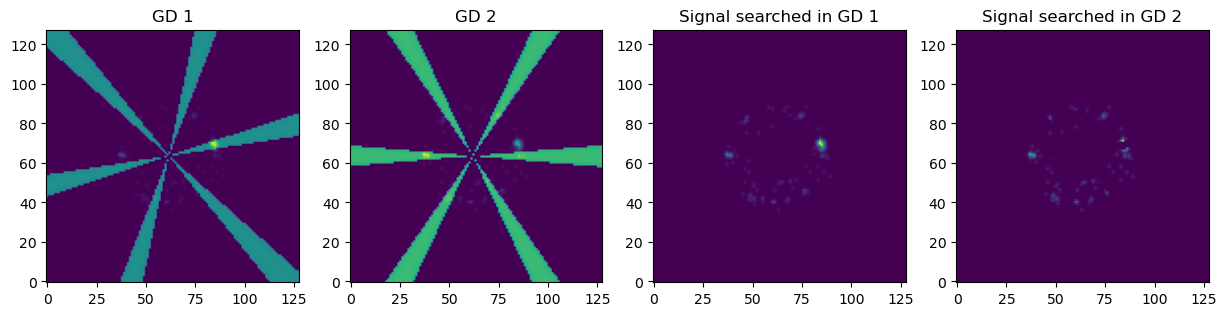

10s: offset 1 = 2.33137553340312, offset 2 = -5.237113060933587
Optimizing offset 1...
Optimizing offset 2...


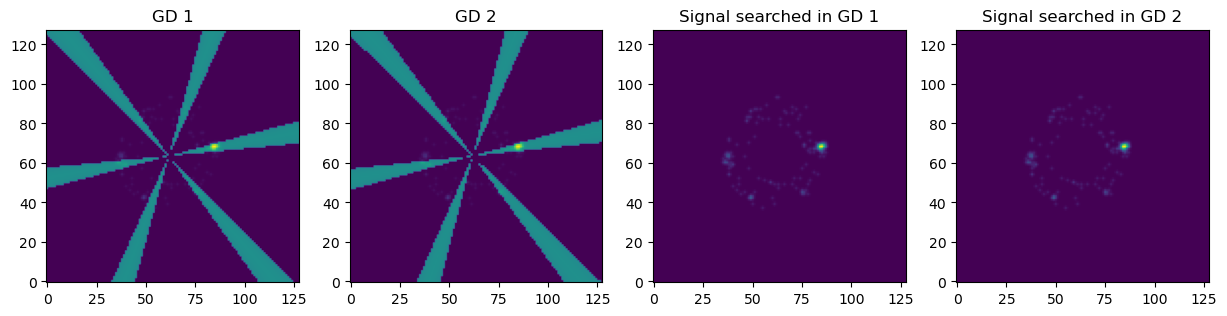

20s: offset 1 = -2.962598263389747, offset 2 = -2.9537344296013304
Optimizing offset 1...
Optimizing offset 2...


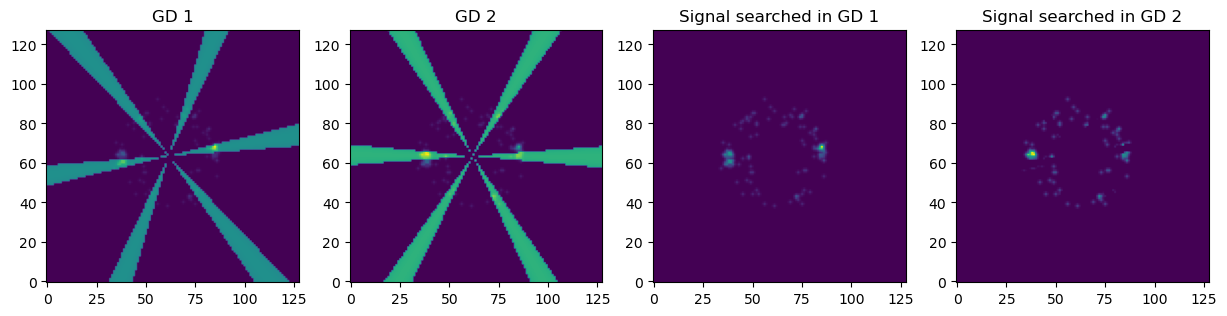

30s: offset 1 = -8.218727056311074, offset 2 = -5.245342803814496
Optimizing offset 1...
Optimizing offset 2...


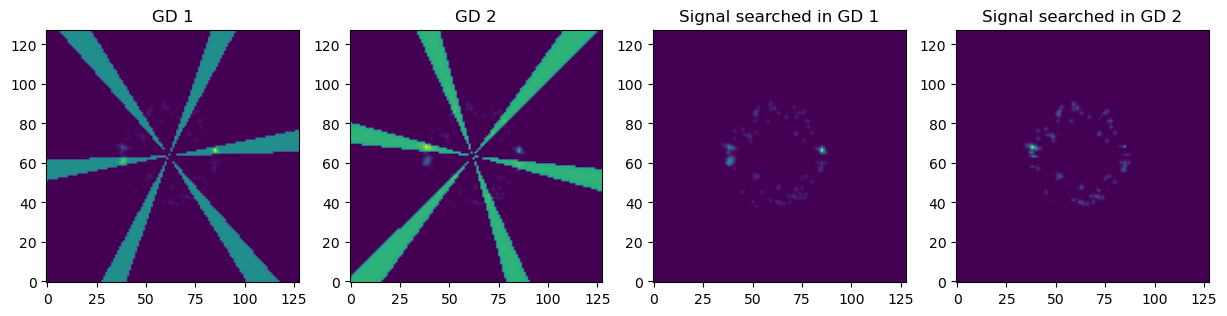

40s: offset 1 = -13.498629074225384, offset 2 = -7.514345418253288
Optimizing offset 1...
Optimizing offset 2...


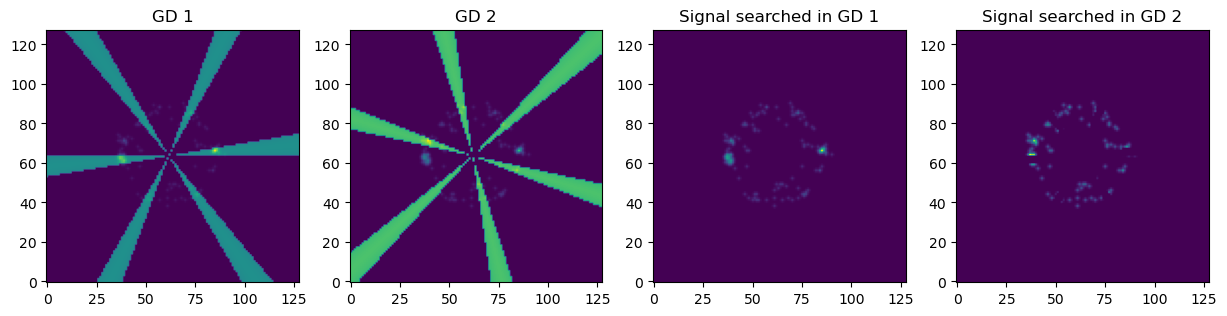

50s: offset 1 = -18.764250312492127, offset 2 = -11.815997615859292
Optimizing offset 1...
Optimizing offset 2...


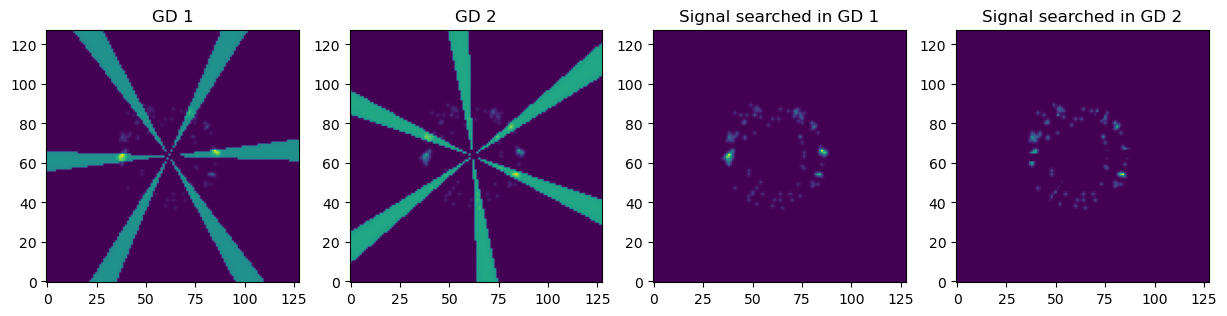

60s: offset 1 = -24.040410983434825, offset 2 = -17.16436177618437
Optimizing offset 1...
Optimizing offset 2...


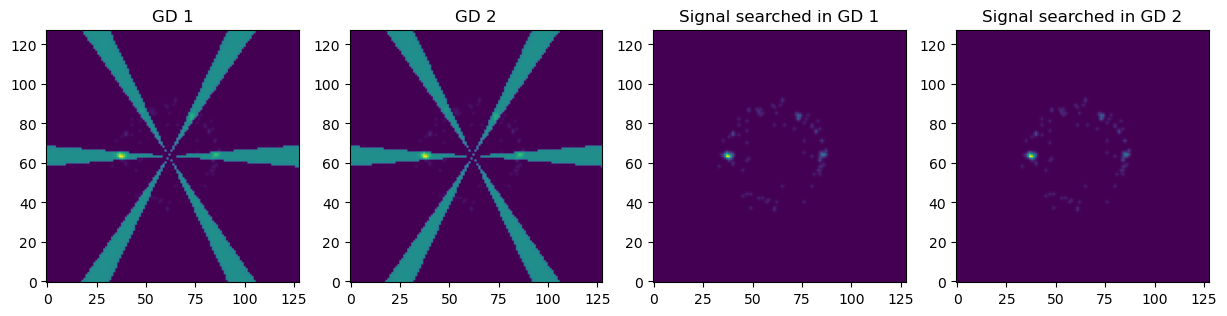

70s: offset 1 = -29.322048490670582, offset 2 = -15.707345320412266
Optimizing offset 1...
Optimizing offset 2...


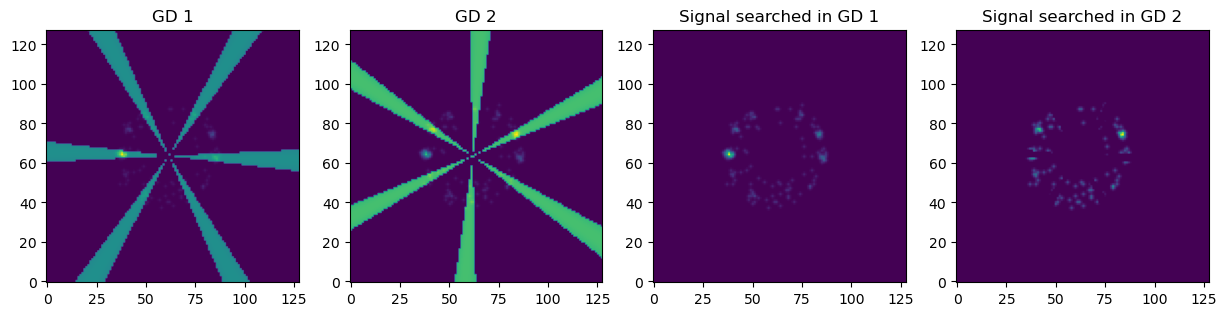

80s: offset 1 = -24.119973281629402, offset 2 = -11.055300545386057
Optimizing offset 1...
Optimizing offset 2...


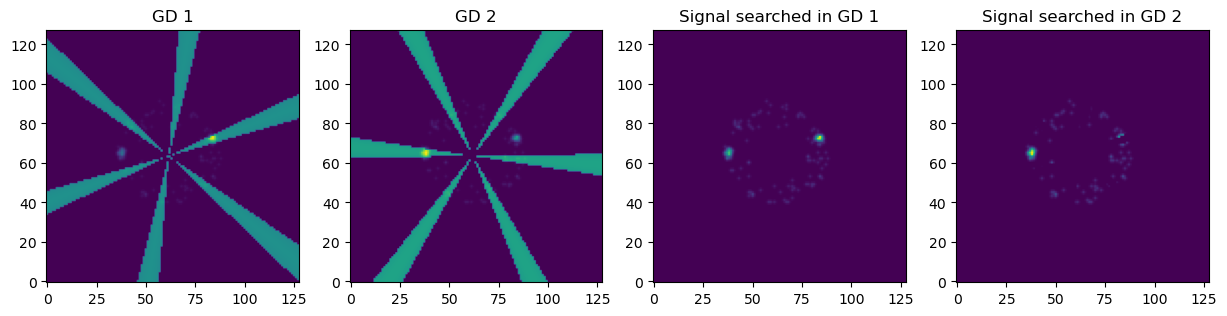

90s: offset 1 = -19.534602706305236, offset 2 = -11.58783908458857
Optimizing offset 1...
Optimizing offset 2...


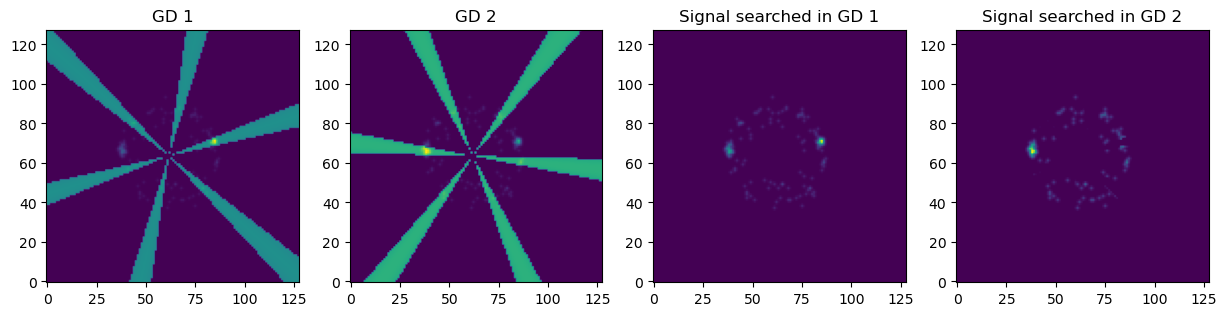

100s: offset 1 = -15.40557099790943, offset 2 = -16.86223192559034
Optimizing offset 1...
Optimizing offset 2...


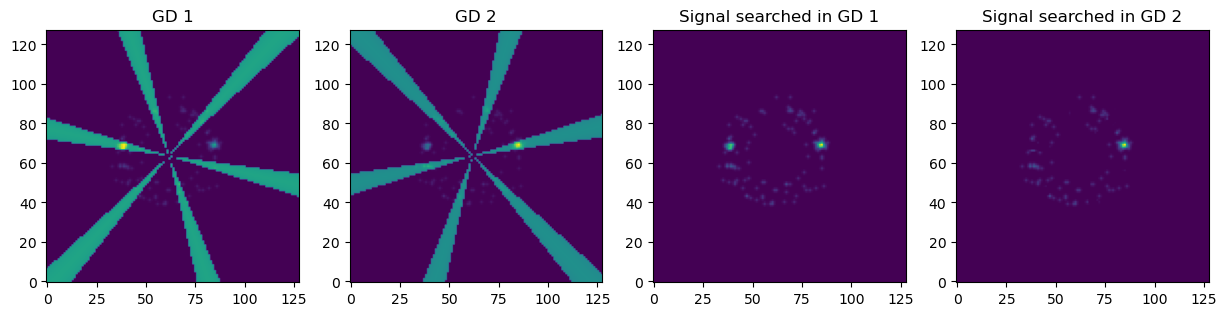

110s: offset 1 = -10.69083527030001, offset 2 = -14.432985421300035
Optimizing offset 1...
Optimizing offset 2...


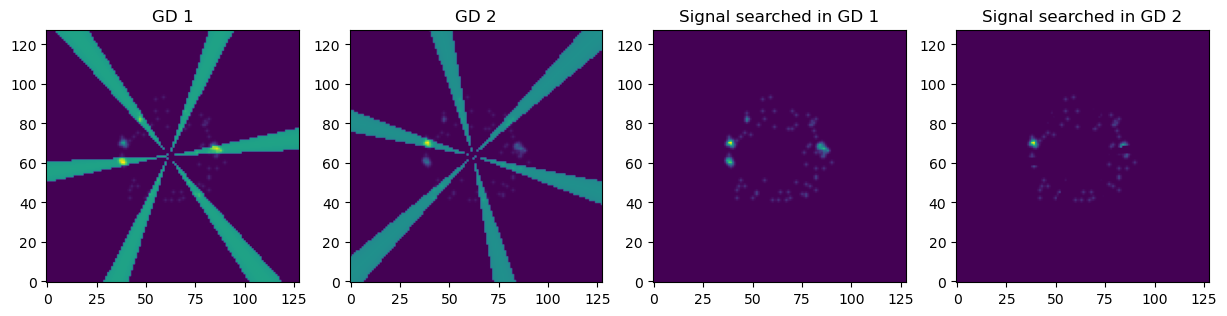

120s: offset 1 = -8.248517164106145, offset 2 = -17.032127350096417
Optimizing offset 1...
Optimizing offset 2...


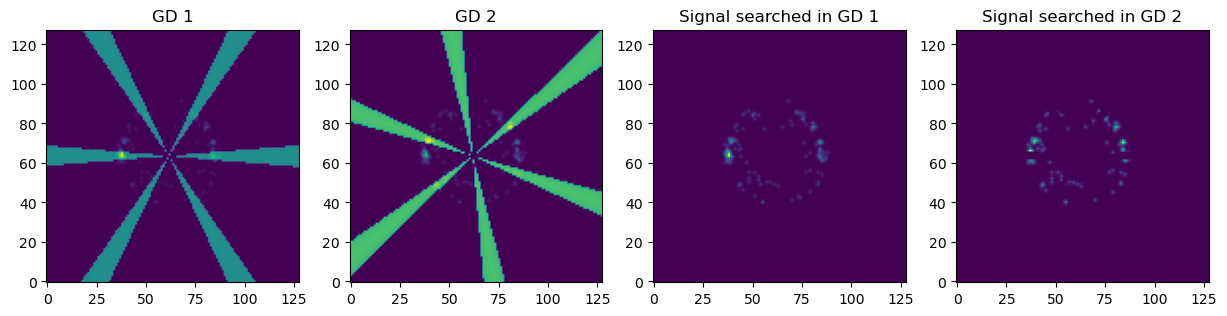

130s: offset 1 = -13.615567326104097, offset 2 = -22.345782589916794
Optimizing offset 1...
Optimizing offset 2...


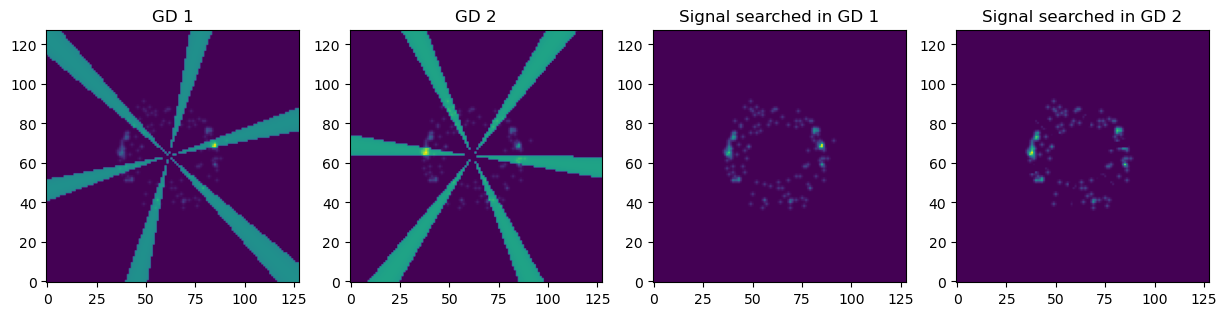

140s: offset 1 = -11.246926778895059, offset 2 = -19.984951563861483
Optimizing offset 1...
Optimizing offset 2...


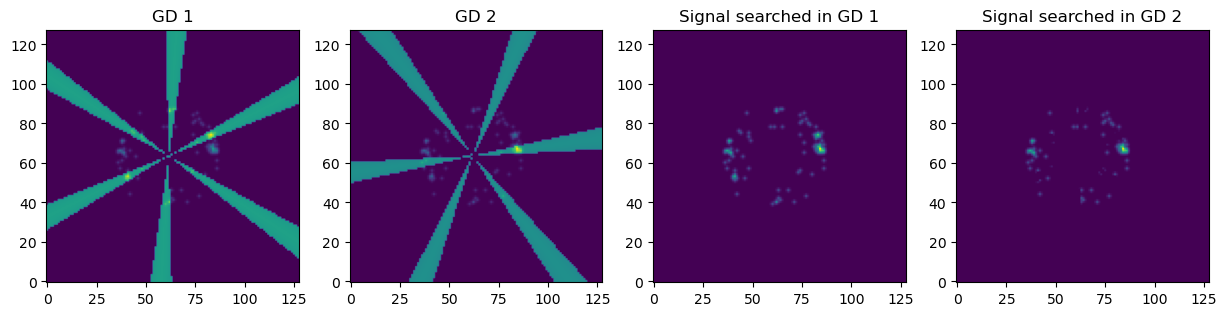

150s: offset 1 = -10.008473598085189, offset 2 = -17.667789973292386
Optimizing offset 1...
Optimizing offset 2...


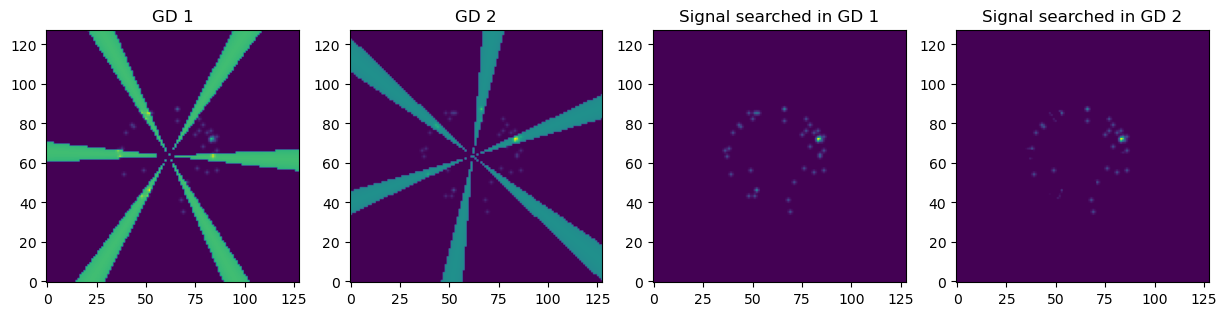

160s: offset 1 = -9.456610067642027, offset 2 = -15.346469094425846
Optimizing offset 1...
Optimizing offset 2...


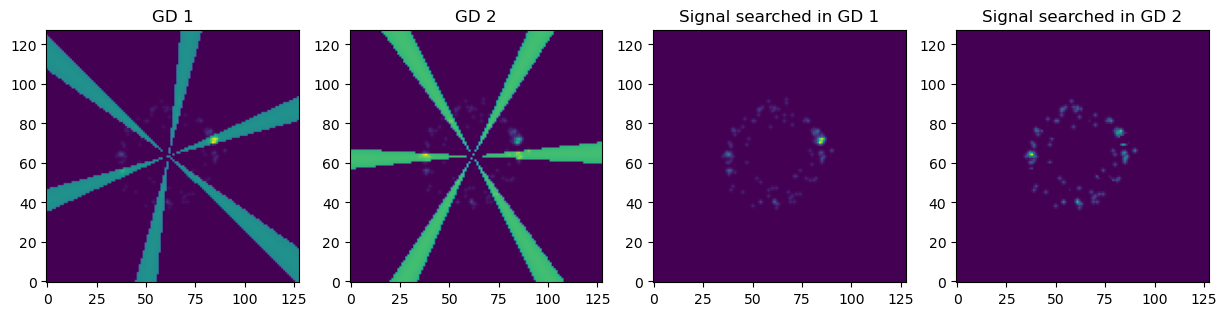

170s: offset 1 = -9.077447819192745, offset 2 = -15.68394992993286
Optimizing offset 1...
Optimizing offset 2...


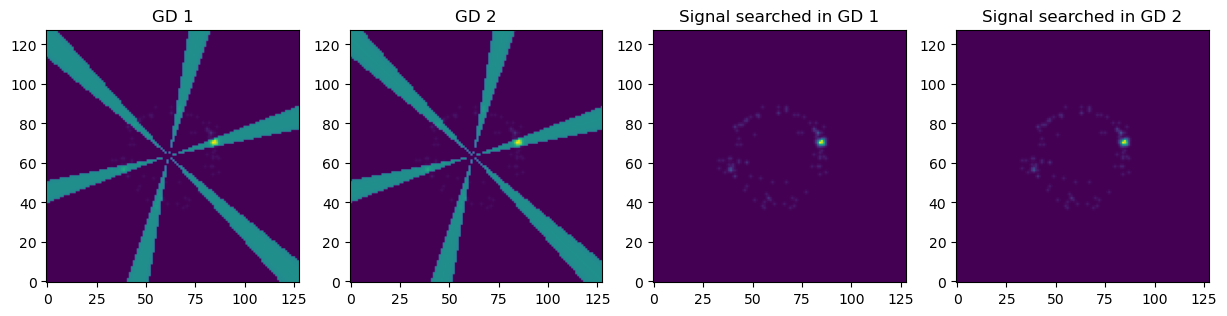

180s: offset 1 = -14.375817712684263, offset 2 = -13.332112289334013
Optimizing offset 1...
Optimizing offset 2...


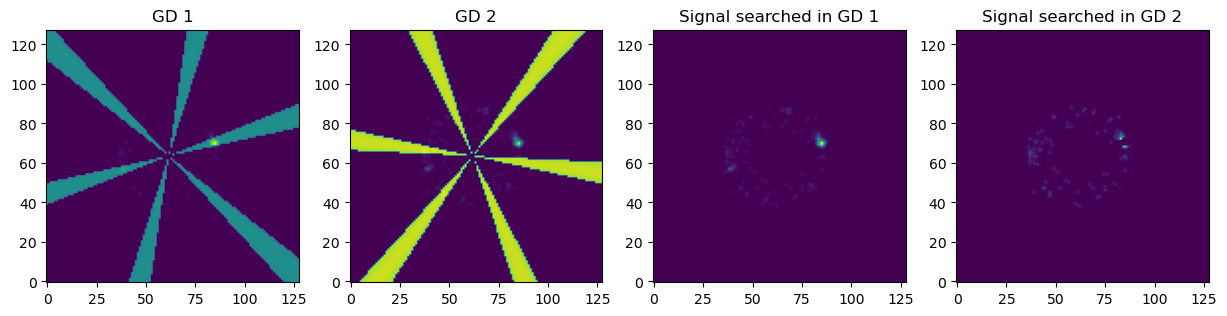

190s: offset 1 = -19.598405250225962, offset 2 = -12.695427433486818
Optimizing offset 1...
Optimizing offset 2...


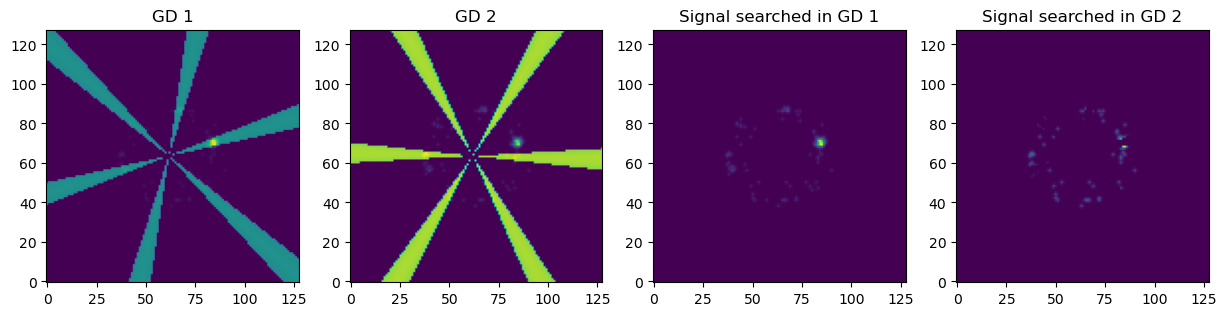

200s: offset 1 = -24.835676786965717, offset 2 = -7.355598367561741


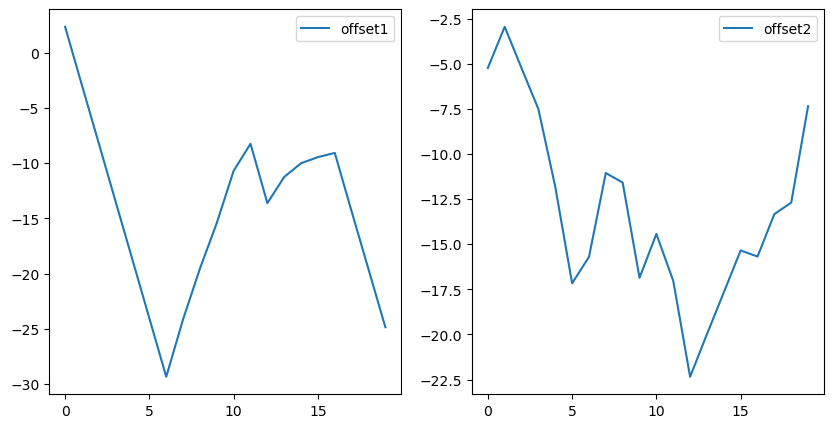

[2.33137553340312, -2.962598263389747, -8.218727056311074, -13.498629074225384, -18.764250312492127, -24.040410983434825, -29.322048490670582, -24.119973281629402, -19.534602706305236, -15.40557099790943, -10.69083527030001, -8.248517164106145, -13.615567326104097, -11.246926778895059, -10.008473598085189, -9.456610067642027, -9.077447819192745, -14.375817712684263, -19.598405250225962, -24.835676786965717]
[-5.237113060933587, -2.9537344296013304, -5.245342803814496, -7.514345418253288, -11.815997615859292, -17.16436177618437, -15.707345320412266, -11.055300545386057, -11.58783908458857, -16.86223192559034, -14.432985421300035, -17.032127350096417, -22.345782589916794, -19.984951563861483, -17.667789973292386, -15.346469094425846, -15.68394992993286, -13.332112289334013, -12.695427433486818, -7.355598367561741]


In [48]:
# Hyperparameters to tune
laser_threshold = 0.94
# you can also change angle_above_offset in the next chunk

# Loop through the movie
offset_list1, offset_list2 = [], []
offset1 = 0#torch.tensor(0., requires_grad=True)
offset2 = 0#torch.tensor(0., requires_grad=True)
for index, image in enumerate(intensity_data):
    offset1, offset2 = optimize_offset_2filters(image, offset1, offset2, laser_threshold=laser_threshold)
    print(f'{(index + 1) * 10}s: offset 1 = {offset1}, offset 2 = {offset2}')
    offset_list1.append(offset1), offset_list2.append(offset2)
    #print(f'{(index + 1) * 10}s: offset 1 = {np.rad2deg(offset1.item())}, offset 2 = {np.rad2deg(offset2.item())}')
    #offset_list1.append(np.rad2deg(offset1.item())), offset_list2.append(np.rad2deg(offset2.item()))

# Plot offset angles
time = np.array(range(len(offset_list1))) * 10 + 10
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(offset_list1, label="offset1")
ax[1].plot(offset_list2, label="offset2")
ax[0].legend()
ax[1].legend()
plt.show()

print(offset_list1)
print(offset_list2)

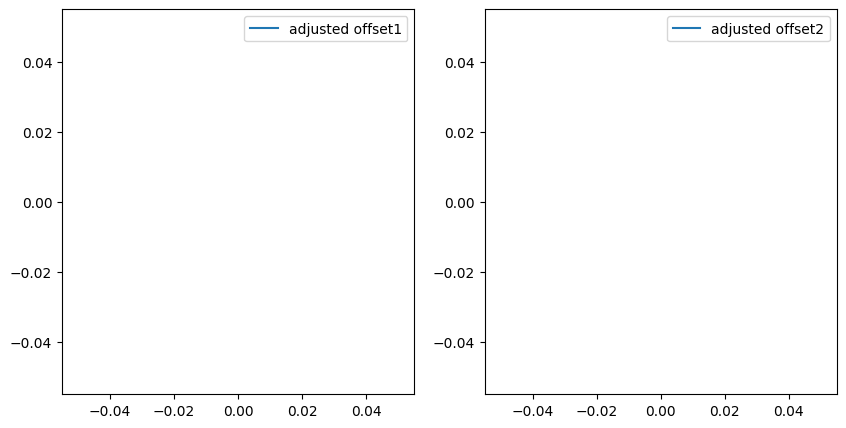

In [ ]:
# If you want to fix snapback
adjusted_offset_list1 = offset_list1#adjust_offset_within_bounds(offset_list1, angle_above_offset=10)
adjusted_offset_list2 = offset_list2#adjust_offset_within_bounds(offset_list2, angle_above_offset=20)

# Plot offset angles
time = np.array(range(len(offset_list1))) * 10 + 10
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(adjusted_offset_list1, label="adjusted offset1")
ax[1].plot(adjusted_offset_list2, label="adjusted offset2")
ax[0].legend()
ax[1].legend()
plt.show()

# Save model data
adjusted_offset_list1=np.array(adjusted_offset_list1)
adjusted_offset_list2=np.array(adjusted_offset_list2)
# file_path = r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Peak Tracking npz files\\'
file_path = rf'/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/Field_Sweep_data/angles/'
full_path = file_path + gif
np.savez(full_path, gif, offset1=adjusted_offset_list1, offset2=adjusted_offset_list2, time=time)



# Angular velocity calculation

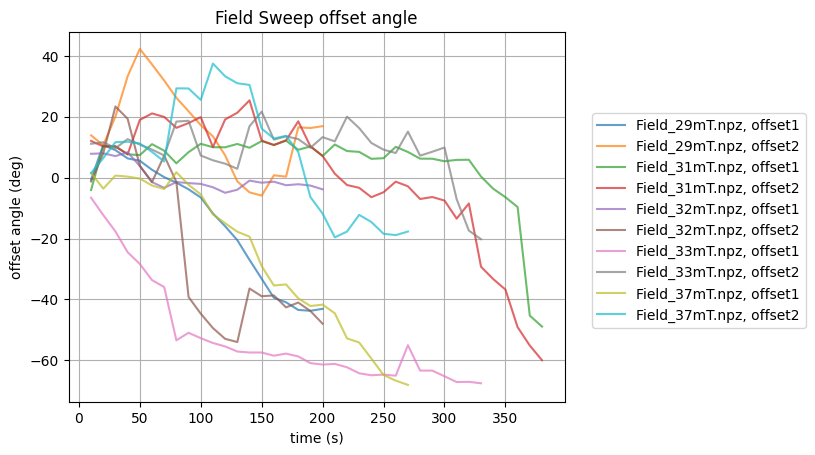

In [ ]:
movies = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz','Field_37mT.npz']

for gif in movies:
    # ratchet_model_data = np.load(rf'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Peak Tracking npz files\{gif}')
    ratchet_model_data = np.load(rf'/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/Field_Sweep_data/angles/{gif}')
    rm_time = ratchet_model_data['time']
    rm_offset1 = ratchet_model_data['offset1']
    rm_offset2 = ratchet_model_data['offset2']
    plt.plot(rm_time, rm_offset1, label=f'{gif}, offset1', alpha=.7)
    plt.plot(rm_time, rm_offset2, label=f'{gif}, offset2', alpha=.7)

plt.xlabel('time (s)')
# plt.xlim(0, 380)
plt.ylabel('offset angle (deg)')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.8))
plt.title('Field Sweep offset angle')
# plt.tight_layout()
# plt.savefig(r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Exported Figures\FieldSweepPositions.png')
plt.show()


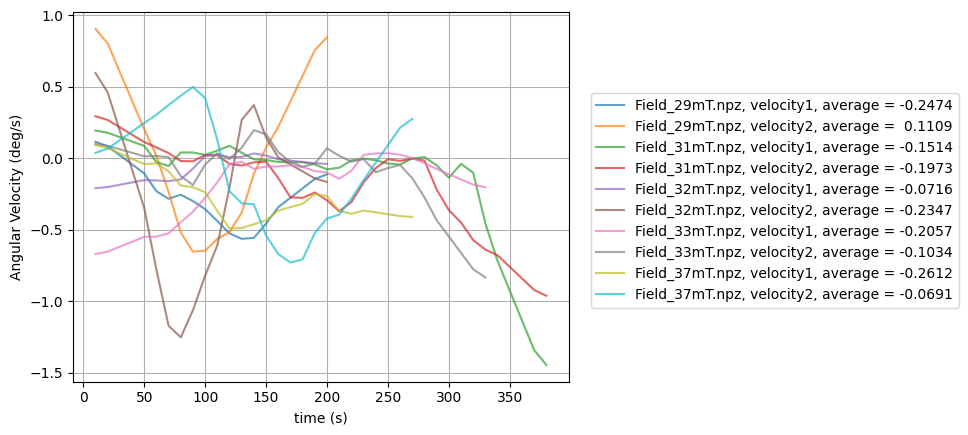

In [ ]:
from scipy.signal import savgol_filter
def compute_smoothed_derivative(time, offset, window_length=11, polyorder=2):
    '''compute velocity of data after savgol_filter is applied'''
    smoothed_angle = savgol_filter(offset, window_length=window_length, polyorder=polyorder)
    time = np.array(time)
    smoothed_derivative = (np.gradient(smoothed_angle, time))
    return smoothed_derivative

# calculate angular velo and plot
for gif in movies:
    # ratchet_model_data = np.load(rf'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Peak Tracking npz files\{gif}')
    ratchet_model_data = np.load(rf'/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/Field_Sweep_data/angles/{gif}')
    rm_time = ratchet_model_data['time']
    rm_offset1 = ratchet_model_data['offset1']
    rm_offset2 = ratchet_model_data['offset2']
    velo1 = compute_smoothed_derivative(rm_time, rm_offset1)
    velo2 = compute_smoothed_derivative(rm_time, rm_offset2)
    plt.plot(rm_time, velo1, label=f'{gif}, velocity1, average = {np.mean(velo1): .04f}', alpha=.7)
    plt.plot(rm_time, velo2, label=f'{gif}, velocity2, average = {np.mean(velo2): .04f}', alpha=.7)

plt.xlabel('time (s)')
# plt.xlim(0,380)
plt.ylabel('Angular Velocity (deg/s)')
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.8))
# plt.title('Ratchet Model')
plt.grid(True)
# plt.savefig(r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Exported Figures\FieldSweepVelocities.png')
plt.show()